## <center>Лабораторная работа №27-28</center>

**Тема:** Разработка, отладка и испытание программ анализа данных над объектами библиотеки Pandas 

**Цель:** Получить навыки анализа данных из открытых источников. 

**Материал:** [Лекция 6.3  Библиотека Pandas](../../material/lectures/lect06_03.ipynb) 

### <center>Еще один пример анализа данных с предварительной оптимизацией</center>

При использовании библиотеки pandas для анализа маленьких наборов данных, размер которых не превышает 100 мегабайт, производительность редко становится проблемой. Но когда речь идет об исследовании наборов данных, размеры которых могут достигать нескольких гигабайт, проблемы с производительностью могут приводить к значительному увеличению длительности анализа данных и даже могут становиться причиной невозможности проведения анализа из-за нехватки памяти.

В этом примерере поговорим об особенностях работы с памятью при использовании pandas, и о том, как, просто подбирая подходящие типы данных, хранящихся в столбцах табличных структур данных DataFrame, снизить потребление памяти почти на 90%.

#### <center>Данные по бейсбольным играм Главной лиги, собранные за 130 лет и взятые с [Retrosheet](http://www.retrosheet.org/gamelogs/index.html).</center>

Начнем с импорта набора данных и взглянем на его первые пять строк.

In [ ]:
import pandas as pd

gl = pd.read_csv('pandas_files/game_logs.csv')
gl.head()

Ниже приведены сведения о наиболее важных столбцах таблицы с этими данными. Если вы хотите почитать пояснения по всем столбцам — [здесь](https://data.world/dataquest/mlb-game-logs/workspace/data-dictionary) вы можете найти словарь данных для всего набора данных.

    date — Дата проведения игры.
    v_name — Название команды гостей.
    v_league — Лига команды гостей.
    h_name — Название команды хозяев.
    h_league — Лига команды хозяев.
    v_score — Очки команды гостей.
    h_score — Очки команды хозяев.
    v_line_score — Сводка по очкам команды гостей, например — 010000(10)00.
    h_line_score — Сводка по очкам команды хозяев, например — 010000(10)0X.
    park_id — Идентификатор поля, на котором проводилась игра.
    attendance — Количество зрителей.


Для того чтобы узнать общие сведения об объекте DataFrame, можно воспользоваться методом DataFrame.info(). Благодаря этому методу можно узнать о размере объекта, о типах данных и об использовании памяти.

По умолчанию pandas, ради экономии времени, указывает приблизительные сведения об использовании памяти объектом DataFrame, поэтому установим параметр memory_usage в значение 'deep'.

In [ ]:
gl.info(memory_usage='deep')

Как оказалось, у нас имеется 171907 строк и 161 столбец. Библиотека pandas автоматически выяснила типы данных. Здесь присутствует 83 столбца с числовыми данными и 78 столбцов с объектами. Объектные столбцы используются для хранения строковых данных, и в тех случаях, когда столбец содержит данные разных типов.

Теперь, для того, чтобы лучше понять то, как можно оптимизировать использование памяти этим объектом DataFrame, давайте поговорим о том, как pandas хранит данные в памяти.

#### Внутреннее представление объекта DataFrame

Внутри pandas столбцы данных группируются в блоки со значениями одинакового типа. Вот пример того, как в pandas хранятся первые 12 столбцов объекта DataFrame.
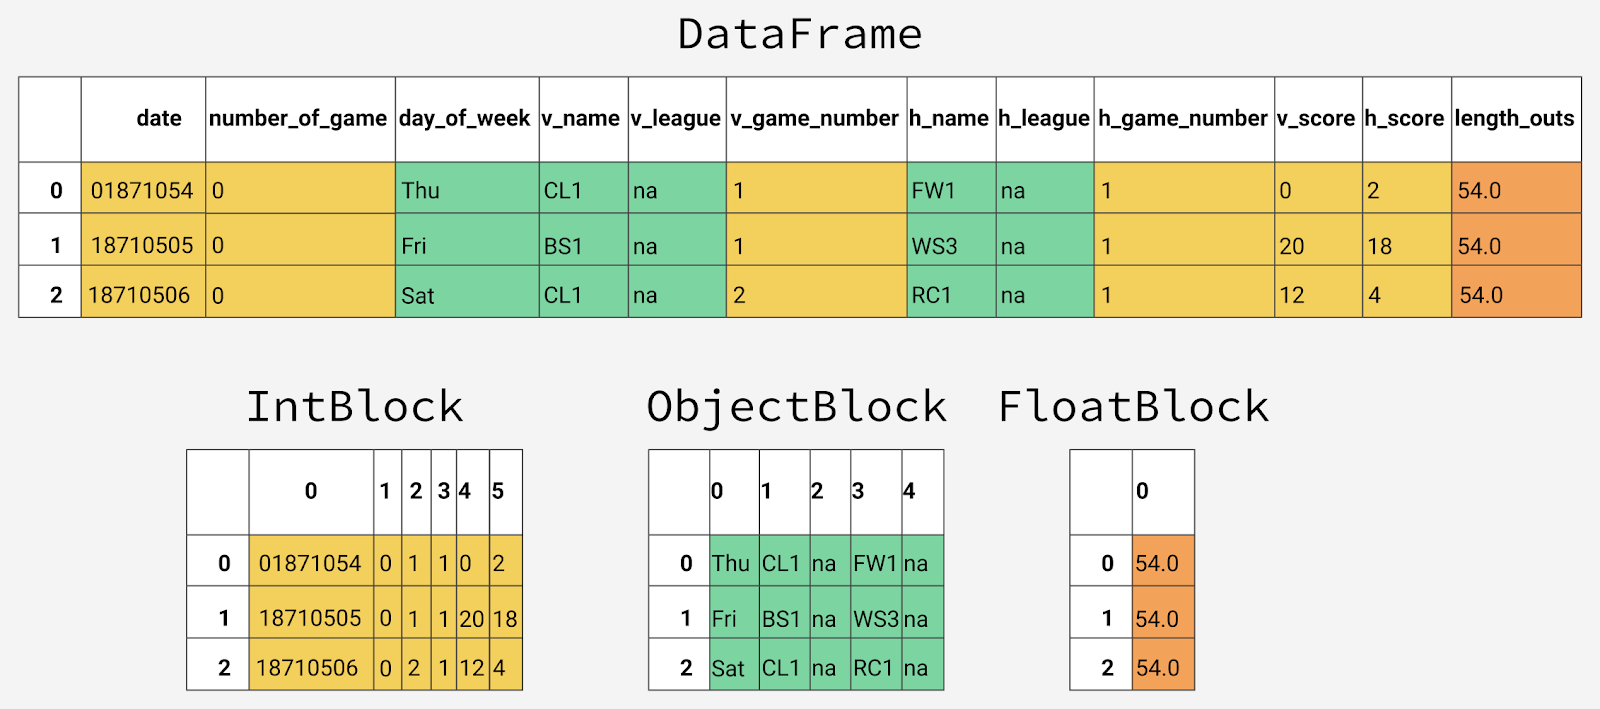
<i><center>Внутреннее представление данных разных типов в pandas</center></i>

Можно заметить, что блоки не хранят сведения об именах столбцов. Происходит это из-за того, что блоки оптимизированы для хранения значений, имеющихся в ячейках таблицы объекта DataFrame. За хранение сведений о соответствии между индексами строк и столбцов набора данных и того, что хранится в блоках однотипных данных, отвечает класс BlockManager. Он играет роль API, который предоставляет доступ к базовым данным. Когда мы читаем, редактируем или удаляем значения, класс DataFrame взаимодействует с классом BlockManager для преобразования наших запросов в вызовы функций и методов.

Каждый тип данных имеет специализированный класс в модуле pandas.core.internals. Например, pandas использует класс ObjectBlock для представления блоков, содержащих строковые столбцы, и класс FloatBlock для представления блоков, содержащих столбцы, хранящие числа с плавающей точкой. Для блоков, представляющих числовые значения, выглядящие как целые числа или числа с плавающей точкой, pandas комбинирует столбцы и хранит их в виде структуры данных ndarray библиотеки NumPy. Эта структура данных построена на основе массива C, значения хранятся в непрерывном блоке памяти. Благодаря такой схеме хранения данных доступ к фрагментам данных осуществляется очень быстро.

Так как данные разных типов хранятся раздельно, исследуем использование памяти разными типами данных. Начнем со среднего показателя использования памяти по разным типам данных.

In [ ]:
for dtype in ['float','int','object']:
    selected_dtype = gl.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Эти сведения дают нам понять то, что большая часть памяти уходит на 78 столбцов, хранящих объектные значения. Мы еще поговорим об этом позже, а сейчас давайте подумаем о том, можем ли мы улучшить использование памяти столбцами, хранящими числовые данные.

#### Подтипы

Как мы уже говорили, pandas представляет числовые значения в виде структур данных ndarray NumPy и хранит их в непрерывных блоках памяти. Эта модель хранения данных позволяет экономно расходовать память и быстро получать доступ к значениям. Так как pandas представляет каждое значение одного и того же типа, используя одинаковое число байт, и структуры ndarray хранят сведения о числе значений, pandas может быстро и точно выдать сведения об объеме памяти, потребляемых столбцами, хранящими числовые значения.

У многих типов данных в pandas есть множество подтипов, которые могут использовать меньшее число байт для представления каждого значения. Например тип float имеет подтипы float16, float32 и float64. Число в имени типа указывает на количество бит, которые подтип использует для представления значений. Например, в только что перечисленных подтипах для хранения данных используется, соответственно, 2, 4, 8 и 16 байт. В следующей таблице представлены подтипы наиболее часто используемых в pandas типов данных.
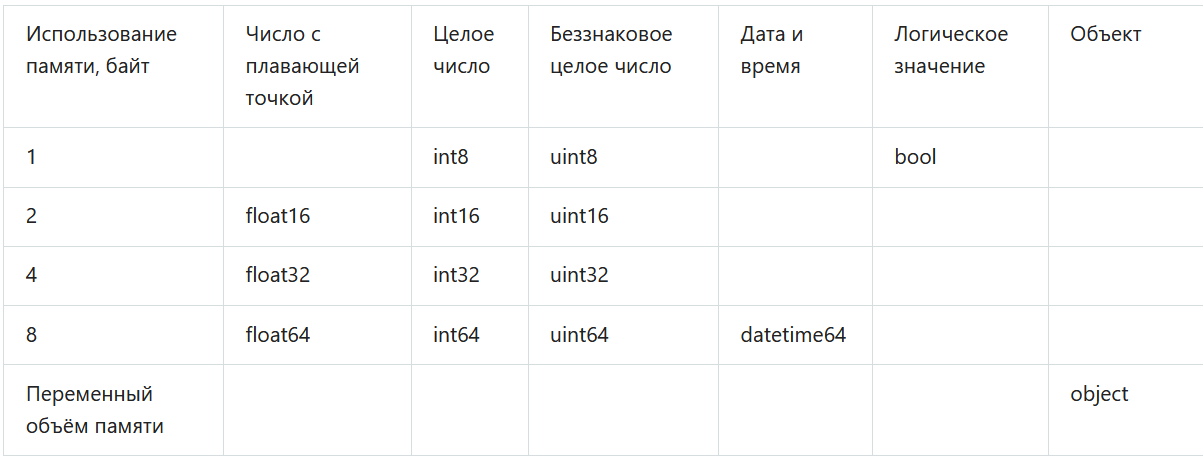
Значение типа int8 использует 1 байт (8 бит) для хранения числа и может представлять 256 двоичных значений (2 в 8 степени). Это означает, что этот подтип можно использовать для хранения значений в диапазоне от -128 до 127 (включая 0).

Для проверки минимального и максимального значения, подходящего для хранения с использованием каждого целочисленного подтипа, можно воспользоваться методом numpy.iinfo(). Рассмотрим пример:

In [ ]:
import numpy as np
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Выполнив этот код, можно обратить внимание на различие между типами uint (беззнаковое целое) и int (целое число со знаком). Оба типа имеют одинаковую ёмкость, но, при хранении в столбцах только положительных значений, беззнаковые типы позволяют эффективнее расходовать память.

#### Оптимизация хранения числовых данных с использованием подтипов
Функцию pd.to_numeric() можно использовать для нисходящего преобразования числовых типов. Для выбора столбцов с плавающей точкой воспользуемся методом DataFrame.select_dtypes(), затем оптимизируем их и сравним использование памяти до и после оптимизации.

In [ ]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

gl_float = gl.select_dtypes(include=['float'])
converted_float = gl_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(gl_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([gl_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['До','После']
compare_floats.apply(pd.Series.value_counts)

В результате все столбцы, хранившие числа с плавающей точкой с типом данных float64, теперь хранят числа типа float32, что дало нам 50% уменьшение использования памяти.

#### Сравнение механизмов хранения чисел и строк

Тип object представляет значения с использованием строковых объектов Python. Отчасти это так от того, что NumPy не поддерживает представление отсутствующих строковых значений. Так как Python — это высокоуровневый интерпретируемый язык, он не даёт программисту инструментов для тонкого управления тем, как данные хранятся в памяти.

Это ограничение ведёт к тому, что строки хранятся не в непрерывных фрагментах памяти, их представление в памяти фрагментировано. Это ведёт к увеличению потребления памяти и к замедлению скорости работы со строковыми значениями. Каждый элемент в столбце, хранящем объектный тип данных, на самом деле, представляет собой указатель, который содержит «адрес», по которому настоящее значение расположено в памяти.

Ниже показана схема, созданная на основе этого материала, на которой сравнивается хранение числовых данных с использованием типов данных NumPy и хранение строк с применением встроенных типов данных Python.
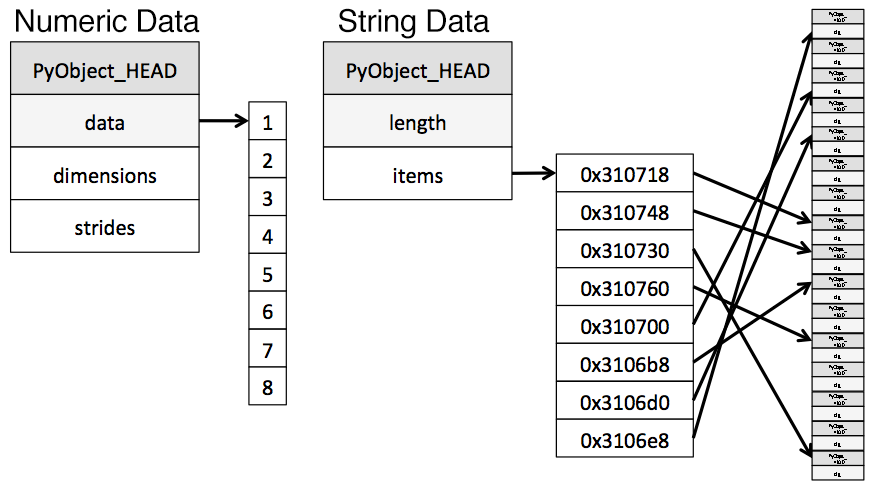
Тут можно вспомнить о том, что выше, в одной из таблиц, было показано, что для хранения данных объектных типов используется переменный объем памяти. Хотя каждый указатель занимает 1 байт памяти, каждое конкретное строковое значение занимает тот же объем памяти, который использовался бы для хранения отдельно взятой строки в Python. Для того чтобы это подтвердить, воспользуемся методом sys.getsizeof(). Сначала взглянем на отдельные строки, а затем на объект Series pandas, хранящий строковые данные.

Итак, сначала исследуем обычные строки:

In [ ]:
from sys import getsizeof

s1 = 'working out'
s2 = 'memory usage for'
s3 = 'strings in python is fun!'
s4 = 'strings in python is fun!'

for s in [s1, s2, s3, s4]:
    print(getsizeof(s))

Теперь посмотрим на то, как выглядит использование строк в объекте Series:

In [ ]:
obj_series = pd.Series(['working out',
                        'memory usage for',
                        'strings in python is fun!',
                        'strings in python is fun!'])
obj_series.apply(getsizeof)

Можно видеть, что размеры строк, хранящихся в объектах Series pandas, аналогичны их размерам при работе с ними в Python и при представлении их в виде самостоятельных сущностей.

#### Оптимизация хранения данных объектных типов с использованием категориальных переменных

Категориальные переменные появились в pandas версии 0.15. Соответствующий тип, category, использует в своих внутренних механизмах, вместо исходных значений, хранящихся в столбцах таблицы, целочисленные значения. Pandas использует отдельный словарь, устанавливающий соответствия целочисленных и исходных значений. Такой подход полезен в тех случаях, когда столбцы содержат значения из ограниченного набора. Когда данные, хранящиеся в столбце, конвертируют в тип category, pandas использует подтип int, который позволяет эффективнее всего распорядиться памятью и способен представить все уникальные значения, встречающиеся в столбце.
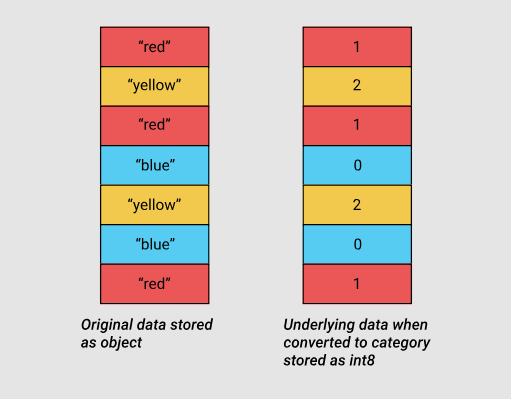
<i><center>Исходные данные и категориальные данные, использующие подтип int8</center></i>

Для того чтобы понять, где именно мы сможем воспользоваться категориальными данными для снижения потребления памяти, выясним количество уникальных значений в столбцах, хранящих значения объектных типов:

In [ ]:
gl_obj = gl.select_dtypes(include=['object']).copy()
gl_obj.describe()

Например, в столбце day_of_week, представляющем собой день недели, в который проводилась игра, имеется 171907 значений. Среди них всего 7 уникальных. В целом же, одного взгляда на этот отчет достаточно для того, чтобы понять, что во многих столбцах для представления данных примерно 172000 игр используется довольно-таки мало уникальных значений.

Прежде чем мы займемся полномасштабной оптимизацией, давайте выберем какой-нибудь один столбец, хранящий объектные данные, да хотя бы day_of_week, и посмотрим, что происходит внутри программы при преобразовании его в категориальный тип.

Как уже было сказано, в этом столбце содержится всего 7 уникальных значений. Для преобразования его в категориальный тип воспользуемся методом .astype().

In [ ]:
dow = gl_obj.day_of_week
print(dow.head())

dow_cat = dow.astype('category')
print(dow_cat.head())

Хотя тип столбца изменился, данные, хранящиеся в нем, выглядят так же, как и раньше. Посмотрим теперь на то, что происходит внутри программы.

В следующем коде мы используем атрибут Series.cat.codes для того, чтобы выяснить то, какие целочисленные значения тип category использует для представления каждого из дней недели:


In [ ]:
dow_cat.head().cat.codes

Тут можно заметить то, что каждому уникальному значению назначено целочисленное значение, и то, что столбец теперь имеет тип int8. Здесь нет отсутствующих значений, но если бы это было так, для указания таких значений использовалось бы число -1.

Теперь давайте сравним потребление памяти до и после преобразования столбца day_of_week к типу category.

In [ ]:
print(mem_usage(dow))
print(mem_usage(dow_cat))

Как видно, сначала потреблялось 9.84 мегабайт памяти, а после оптимизации — лишь 0.16 мегабайт, что означает 98% улучшение этого показателя. Обратите внимание на то, что работа с этим столбцом, вероятно, демонстрирует один из наиболее выгодных сценариев оптимизации, когда в столбце, содержащем примерно 172000 элементов, используется лишь 7 уникальных значений.

Хотя идея преобразования всех столбцов к этому типу данных выглядит привлекательно, прежде чем это делать, стоит учитывать негативные побочные эффекты такого преобразования. Так, наиболее серьёзный минус этого преобразования заключается в невозможности выполнения арифметических операций над категориальными данными. Это касается и обычных арифметических операций, и использования методов наподобие Series.min() и Series.max() без предварительного преобразования данных к настоящему числовому типу.

Нам стоит ограничить использование типа category, в основном, столбцами, хранящими данные типа object, в которых уникальными являются менее 50% значений. Если все значения в столбце уникальны, то использование типа category приведет к повышению уровня использования памяти. Это происходит из-за того, что в памяти приходится хранить, в дополнение к числовым кодам категорий, еще и исходные строковые значения.

Создадим цикл, который перебирает все столбцы, хранящие данные типа object, выясняет, не превышает ли число уникальных значений в столбцах 50%, и если это так, преобразует их в тип category.

In [ ]:
converted_obj = pd.DataFrame()

for col in gl_obj.columns:
    num_unique_values = len(gl_obj[col].unique())
    num_total_values = len(gl_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = gl_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = gl_obj[col]

Теперь сравним то, что получилось после оптимизации, с тем, что было раньше:

In [ ]:
print(mem_usage(gl_obj))
print(mem_usage(converted_obj))

compare_obj = pd.concat([gl_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['До','После']
compare_obj.apply(pd.Series.value_counts)

В нашем случае все обрабатываемые столбцы были преобразованы к типу category, однако нельзя говорить о том, что то же самое произойдет при обработке любого набора данных, поэтому, обрабатывая по этой методике свои данные, не забывайте о сравнениях того, что было до оптимизации, с тем, что получилось после её выполнения.

Как видно, объем памяти, необходимый для работы со столбцами, хранящими данные типа object, снизился с 752 мегабайт до 52 мегабайт, то есть на 93%. Теперь давайте посмотрим на то, как нам удалось оптимизировать потребление памяти по всему набору данных. Проанализируем то, на какой уровень использования памяти мы вышли, если сравнить то, что получилось, с исходным показателем в 751 мегабайт.

In [ ]:
optimized_gl[converted_obj.columns] = converted_obj

mem_usage(optimized_gl)

Результат впечатляет. Но мы еще можем кое-что улучшить. Как было показано выше, в нашей таблице имеются данные типа datetime, столбец, хранящий которые, можно использовать в качестве первого столбца набора данных.

In [ ]:
date = optimized_gl.date
print(mem_usage(date))
date.head()

Преобразование выполняется с использованием функции to_datetime(), параметр format которой указывает на то, что данные хранятся в формате YYYY-MM-DD.

In [ ]:
optimized_gl['date'] = pd.to_datetime(date,format='%Y%m%d')

print(mem_usage(optimized_gl))
optimized_gl.date.head()

#### Выбор типов при загрузке данных

До сих пор мы исследовали способы уменьшения потребления памяти существующим объектом DataFrame. Мы сначала считывали данные в их исходном виде, затем, пошагово, занимались их оптимизацией, сравнивая то, что получилось, с тем, что было. Это позволило как следует разобраться с тем, чего можно ожидать от тех или иных оптимизаций. Как уже было сказано, часто для представления всех значений, входящих в некий набор данных, может попросту не хватить памяти. В связи с этим возникает вопрос о том, как применить методики экономии памяти в том случае, если нельзя даже создать объект DataFrame, который предполагается оптимизировать.

К счастью, оптимальные типы данных для отдельных столбцов можно указать ещё до фактической загрузки данных. Функция pandas.read_csv() имеет несколько параметров, позволяющих это сделать. Так, параметр dtype принимает словарь, в котором присутствуют, в виде ключей, строковые имена столбцов, и в виде значений — типы NumPy.

Для того чтобы воспользоваться этой методикой, мы сохраним итоговые типы всех столбцов в словаре с ключами, представленными именами столбцов. Но для начала уберtм столбец с датой проведения игры, так как его нужно обрабатывать отдельно.

In [ ]:
dtypes = optimized_gl.drop('date',axis=1).dtypes

dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]

column_types = dict(zip(dtypes_col, dtypes_type))

# вместо вывода всех 161 элементов, мы
# возьмём 10 пар ключ/значение из словаря
# и аккуратно их выведем

preview = first2pairs = {key:value for key,value in list(column_types.items())[:10]}
import pprint
pp = pp = pprint.PrettyPrinter(indent=4)
pp.pprint(preview)

Теперь мы сможем воспользоваться этим словарtм вместе с несколькими параметрами, касающимися данных о датах проведения игр, в ходе загрузки данных.

Соответствующий код получается довольно-таки компактным:

In [ ]:
read_and_optimized = pd.read_csv('pandas_files/game_logs.csv',dtype=column_types,parse_dates=['date'],infer_datetime_format=True)

print(mem_usage(read_and_optimized))
read_and_optimized.head()

В результате объём использования памяти выглядит так: 160.52 MB.

### <center>Анализ бейсбольных матчей</center>

Теперь, после того, как мы оптимизировали данные, можем заняться их анализом. Взглянем на распределение игровых дней.

In [ ]:
optimized_gl['year'] = optimized_gl.date.dt.year
games_per_day = optimized_gl.pivot_table(index='year',columns='day_of_week',values='date',aggfunc=len)
games_per_day = games_per_day.divide(games_per_day.sum(axis=1),axis=0)

ax = games_per_day.plot(kind='area',stacked='true')
ax.legend(loc='upper right')
ax.set_ylim(0,1)
plt.show()

Как видно, до 1920-х годов игры редко проводились по воскресеньям, после чего, примерно в течение 50 лет, игры в этот день постепенно проводились все чаще.

Кроме того, можно заметить, что распределение дней недели, в которые проводились игры последние 50 лет, является практически неизменным.

Теперь взглянем на то, как со временем менялась длительность игр.

In [ ]:
game_lengths = optimized_gl.pivot_table(index='year', values='length_minutes')
game_lengths.reset_index().plot.scatter('year','length_minutes')
plt.show()

Возникает такое ощущение, что с 1940-х годов по настоящее время матчи становятся всё более длительными.

#### Итоги

В этом материале мы обсудили особенности хранения данных разных типов в pandas, после чего воспользовались полученными знаниями для уменьшения объёма памяти, необходимого для хранения объекта DataFrame, почти на 90%. Для этого мы применили две простые методики:

    - Мы произвели нисходящее преобразование типов числовых данных, хранящихся в столбцах, выбрав более эффективные, в плане использования памяти, типы.
    - Мы преобразовали строковые данные к категориальному типу данных.


Нельзя сказать, что оптимизация любого набора данных способна привести к столь же впечатляющим результатам, но, особенно учитывая возможность выполнения оптимизации на этапе загрузки данных, можно говорить о том, что любому, кто занимается анализом данных с помощью pandas, полезно владеть методиками работы, которые мы здесь обсудили.

## <center>Задание для анализа</center>

Данные по вакцинации COVID-19 собираются ежедневно из репозитория «Наш мир» на GitHub, объединяются и выгружаются (файл country_vaccinations.csv в папке IS2\Material\laboratory\pandas_files).

Данные (вакцинации по странам) содержат следующую информацию (некоторые поля и их описание):

    country - это страна, для которой предоставляется информация о вакцинации;
    iso_code - код ISO для страны;
    date - дата ввода данных; для некоторых дат у нас есть только ежедневные прививки, для других - только (кумулятивная) общая вакцинация;
    total_vaccinations - это абсолютное количество прививок в стране;
    people_vaccinated - человек, в зависимости от схемы иммунизации, получит одну или несколько (обычно 2) вакцины; в определенный момент количество прививок может быть больше, чем количество людей;
    people_fully_vaccinated - это количество людей, получивших полный набор прививок в соответствии со схемой иммунизации (обычно 2); в определенный момент времени может быть определенное количество людей, получивших одну вакцину, и другое (меньшее) количество людей, которые получили все вакцины, указанные в схеме;
    daily_vaccinations_raw - количество вакцинаций на эту дату / страну (сырые данные);
    daily_vaccinations - количество вакцинаций на эту дату / страну (итоговые данные);
    total_vaccinations_per_hundred - соотношение (в процентах) между количеством вакцинированных и общей численностью населения на текущий момент в стране;
    people_vaccinated_per_hundred - соотношение (в процентах) между вакцинированным населением и общей численностью населения на текущий момент в стране.




In [ ]:
import pandas as pd

gl = pd.read_csv('pandas_files/country_vaccinations.csv')
gl.head()

Проведите анализ уровня вакцинации и сравните темпы вакцинации в Республике Беларусь за 2021 год со средним уровнем вакцинации в мире.